In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read the dataset and select the signal we are interested in.

In [6]:
file_name = "trn_set_1"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_train1 = pd.read_csv(DATA_PATH, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
print(data_train1.columns)
signal = pd.Series(data_train1['L_T7'], data_train1.index)
signal.head()

Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')


DATETIME
2014-01-06 00:00:00    1.562321
2014-01-06 01:00:00    1.852043
2014-01-06 02:00:00    2.246126
2014-01-06 03:00:00    3.203573
2014-01-06 04:00:00    4.439714
Name: L_T7, dtype: float64

Let's define a function for discretizing the signal series.

In [8]:
def discretize_signal(signal, n_bins):
    discrete_signal_bins = pd.qcut(signal, n_bins, retbins=True)
    discrete_signal = []
    for discr_bin in discrete_signal_bins[0]:
        discrete_signal.append(discr_bin.right)
    return discrete_signal
    
    

In [16]:
def plot_discrete(x,signal,window, n_bins):
    x = x[:window]
    signal_continuous = signal[:window]
    signal_discretized = discretize_signal(signal_continuous, n_bins)
    fig, ax = plt.subplots(figsize=(17, 7))
    plt.plot(x,signal_continuous)
    plt.step(x,signal_discretized)
    plt.show()

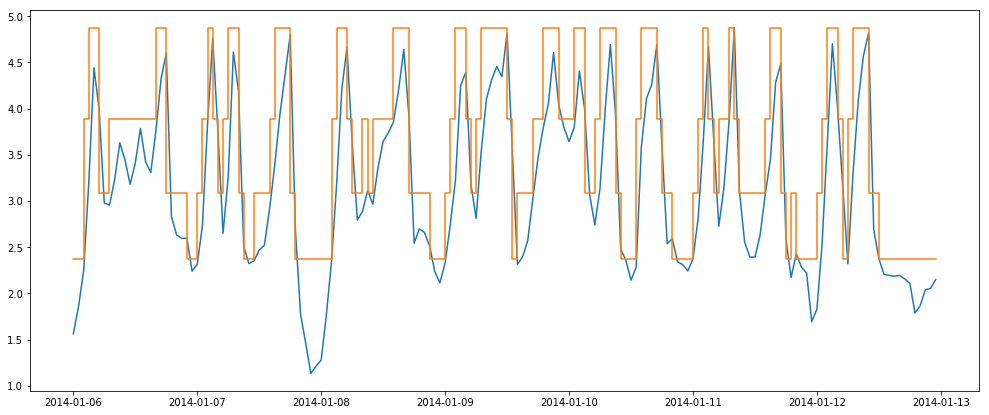

In [19]:
n_bins = 4
n_hours = 24*7
plot_discrete(data_train1.index, signal, n_hours, n_bins)

Let's work on n-grams now. 
First, we define a function for generating all the n-grams given the discretized signal, where n is defined by the user.

In [27]:
n = 3 # for n-grams

In [22]:
def get_ngrams(discrete_signal, n):
    return zip(*[discrete_signal[index:] for index in range(n)])

In [23]:
# uncomment this only if you want to print the ngrams

# ng = get_ngrams(discretize_signal(signal, n_bins),n)
# for ngram in ng:
#    print(ngram)

Let's define a function for computing the probabilities for the generated n-grams based on the given discretized signal. n is defined by the user.

In [24]:
def ngram_probabilities(discrete_signal, n):
    
    #Define a dicitonary for counting each n-gram
    ngrams_count = {}
    
    #Let's generate the n-grams and 
    ngrams = get_ngrams(discrete_signal, n)
    
    for ngram in ngrams:
        if ngram in ngrams_count.keys():
            ngrams_count[ngram] += 1
        else:
            ngrams_count[ngram] = 1
            
    #Compute the total number of ngrams for computing probabilities
    total_ngrams = sum(ngrams_count.values())
    
    #Compute the probability for each n-gram
    for key in ngrams_count.keys():
        ngrams_count[key] = ngrams_count[key]/total_ngrams
        
    #for key in ngrams_count.keys():
    #    print(f"{key}: {ngrams_count[key]}")
        
    return ngrams_count   
    

In [30]:
ngrams_prob_dict = ngram_probabilities(discretize_signal(signal, n_bins),n)

We need to compute the n-grams on the training set 1 because, as specified in the documentation, there are no attacks in that dataset. We need to compute the n-grams probabilities based on normal data and then use these to detect abnormal behaviour in the other dataset.

In [32]:
#discretize the signal
discrete_signal = discretize_signal(signal, n_bins)

#get the ngrams probabilities for this training data
ngrams_prob = ngram_probabilities(discrete_signal, n)

# print(ngrams_prob)

Let's do some smoothing

Sliding window: if we have a too long sliding window, we might end up not detecting any anomaly (if it's too long, most of the ngrams will have been probably seen in the training --> normal behaviour). If we have a too short sliding window, we might end up raising too many alarms: each n-gram which was not in the training would raise an alarm --> too many.

Take the dataset 2, which has attacks, and compute n-grams for the same discretized signal as before.

In [ ]:
file_name = "trn_set_2"
DATA_PATH = r"C:../data/{}.csv".format(file_name)

data_train2 = pd.read_csv(DATA_PATH, parse_dates=['DATETIME'], index_col = ['DATETIME'], dayfirst=True)
signal2 = pd.Series(data_train2['L_T7'])

#discretize the signal
discrete_signal2 = discretize_signal(signal2)

#get the ngrams probabilities for this training data
ngrams_prob2 = ngram_probabilities(discrete_signal2, 2)